<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/err/nifty_%25_above_50_dma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt


import duckdb
import pandas as pd

def calculate_percentage_above_moving_average(periods):
    # Connect to DuckDB
    conn = duckdb.connect("candle_data.duckdb")

    # Query only data from '2018-05-01' onwards
    query = """
        SELECT *
        FROM candle_table
        WHERE date >= '2018-05-01'
        ORDER BY date
    """
    # Read data into a Pandas DataFrame
    data = conn.execute(query).df()

    # Close connection
    conn.close()
    data=data.drop_duplicates(subset=['date'], keep='first')
    # Set index to 'date' and convert to DateTime
    data["date"] = pd.to_datetime(data["date"])
    data.set_index("date", inplace=True)

    # Calculate Exponential Moving Average (EMA)
    ma = data.ewm(span=periods, min_periods=periods).mean()

    # Compute percentage of stocks above moving average
    above_ma = data > ma
    percentage = (above_ma.sum(axis=1) / len(above_ma.columns)) * 100


    return percentage



# Calculate the percentage of stocks above their 200 DMA for each day
percentage_above_dma = calculate_percentage_above_moving_average(50)
percentage_50_dma=calculate_percentage_above_moving_average(10)
# Download the Bank Nifty index data


In [5]:
conn = duckdb.connect("nifty50_data.duckdb")

# Query only data from '2018-05-01' onwards
query = """
    SELECT *
    FROM nifty50_table
    WHERE date >= '2018-05-01'
    ORDER BY date
"""
# Read data into a Pandas DataFrame
nifty = conn.execute(query).df()

# Close connection
conn.close()

In [6]:
nifty=nifty.drop_duplicates(subset=['date'], keep='first')
nifty.dropna(inplace=True)
# Set index to 'date' and convert to DateTime
nifty["date"] = pd.to_datetime(nifty["date"])
nifty.set_index("date", inplace=True)

In [7]:
# Reindex Bank Nifty index data to match percentage_above_dma
aligned_nifty_close = nifty['close']

aligned_nifty_close.head()

,close
date,
2019-09-03,10797.900391
2019-09-04,10844.650391
2019-09-05,10847.900391
2019-09-06,10946.200195
2019-09-09,11003.049805


In [8]:
percentage_above_dma_30_ema=percentage_50_dma.rolling(window=2).mean()
percentage_above_dma_10_ema=percentage_50_dma.rolling(window=1).mean()
percemtage_above_dma_200_30=percentage_above_dma.rolling(window=5).mean()
percemtage_above_dma_200_10=percentage_above_dma.rolling(window=2).mean()

In [9]:
aligned_nifty_close=aligned_nifty_close.tail(250)
percentage_50_dma=percentage_50_dma.tail(250)
percentage_above_dma_10_ema=percentage_above_dma_10_ema.tail(250)
percentage_above_dma_30_ema=percentage_above_dma_30_ema.tail(250)
percemtage_above_dma_200_30=percemtage_above_dma_200_30.tail(250)
percemtage_above_dma_200_10=percemtage_above_dma_200_10.tail(250)

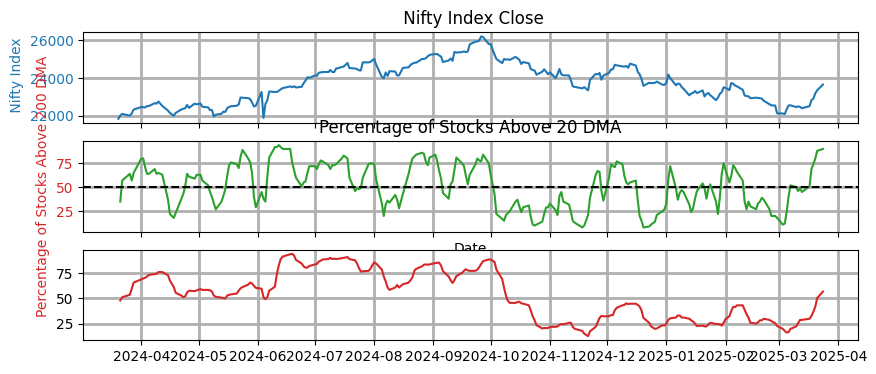

In [10]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,4), sharex=True)

# Plot the Bank Nifty index close
ax1.set_ylabel(' Nifty Index', color='tab:blue')
ax1.plot(aligned_nifty_close.index, aligned_nifty_close, color='tab:blue', label='Nifty Index Close')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title(' Nifty Index Close')

# Plot the percentage of stocks above their 50 DMA
ax2.set_xlabel('Date')
ax2.set_ylabel('Percentage of Stocks Above 200 DMA', color='tab:red')
#ax2.plot(percentage_above_dma.index, percentage_above_dma, color='tab:red', label='Percentage Above 200 DMA')
#ax2.plot(percentage_50_dma.index, percentage_above_dma_10_ema, color='tab:cyan', label='10-day Moving Average')
ax2.plot(percentage_50_dma.index, percentage_above_dma_30_ema, color='tab:green', label='30-day Moving Average')
ax3.plot(percentage_50_dma.index, percemtage_above_dma_200_30, color='tab:red', label='30-day Moving Average')
#ax3.plot(percentage_50_dma.index, percemtage_above_dma_200_10, color='tab:grey', label='10-day Moving Average')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_title('Percentage of Stocks Above 20 DMA')
ax2.axhline(y=50, color='black', linestyle='dashed', label='50% Threshold')
#ax2.legend()

yloc = YearLocator()
mloc = MonthLocator()
ax1.xaxis.set_major_locator(mloc)
ax2.xaxis.set_major_locator(mloc)
ax3.xaxis.set_major_locator(mloc)
#ax[2].xaxis.set_major_locator(mloc)
ax1.grid(linewidth =2)
ax2.grid(linewidth =2)
ax3.grid(linewidth =2)


plt.show()


In [11]:
signal_S=np.where(percemtage_above_dma_200_10>percemtage_above_dma_200_30,1,-1)
signal=np.where(percentage_above_dma_10_ema>percentage_above_dma_30_ema,1,-1)
result=percentage_above_dma_10_ema#-percentage_above_dma_30_ema
result_L = percentage_above_dma_30_ema

In [12]:
aligned_nifty_close=aligned_nifty_close.tail(200)
result=result.tail(200)
result_L=result_L.tail(200)

In [13]:
aligned_nifty_close.tail(5)

,close
date,
2025-03-18,22834.300781
2025-03-19,22907.599609
2025-03-20,23190.650391
2025-03-21,23350.400391
2025-03-24,23658.349609


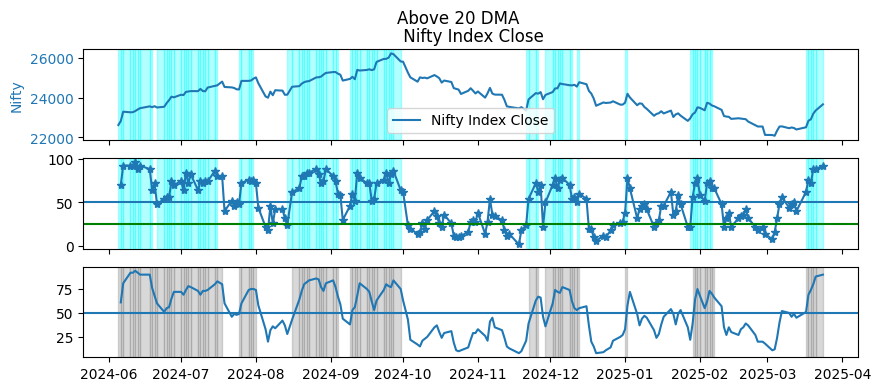

In [14]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(10,4), sharex=True)
ax1.set_ylabel(' Nifty Index', color='tab:blue')
ax1.plot(aligned_nifty_close.index, aligned_nifty_close, color='tab:blue', label='Nifty Index Close')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title(' Nifty Index Close')
ax2.plot(result , label='up',linestyle='-', marker='*')
ax3.plot(result_L , label='up')
ax1.legend(loc='upper left')
ax2.axhline(y=50)
ax3.axhline(y=50)
ax2.axhline(y=25,color='g')
ax1.set_ylabel('Nifty')
ax1.legend('ML Signal')
ax1.legend(loc='best')
fig.suptitle('Above 20 DMA')
# Highlighting the regions where Above 20 DMA is below -20
'''
below_threshold = result < 35

for i in range(1, len(aligned_nifty_close.index)):
    if below_threshold[i] and below_threshold[i-1]:
        ax1.axvspan(aligned_nifty_close.index[i-1], aligned_nifty_close.index[i], color='green', alpha=0.3)
        ax2.axvspan(aligned_nifty_close.index[i-1], aligned_nifty_close.index[i], color='green', alpha=0.3)
'''

below_threshold = result>50 #result < 22
below_threshold_L = result_L>50 #result < 22
for i in range(1, len(aligned_nifty_close.index)):
    if below_threshold[i] and below_threshold[i-1]:
        ax1.axvspan(aligned_nifty_close.index[i-1], aligned_nifty_close.index[i], color='cyan', alpha=0.3)
        ax2.axvspan(aligned_nifty_close.index[i-1], aligned_nifty_close.index[i], color='cyan', alpha=0.3)


for i in range(1, len(aligned_nifty_close.index)):
    if below_threshold_L[i] and below_threshold_L[i-1]:
        #ax1.axvspan(aligned_nifty_close.index[i-1], aligned_nifty_close.index[i], color='green', alpha=0.3)
        ax3.axvspan(aligned_nifty_close.index[i-1], aligned_nifty_close.index[i], color='gray', alpha=0.3)

plt.show()


In [15]:
result[-10:].to_csv('result.csv')

In [16]:
S=np.where(signal_S<0,signal,1)

1


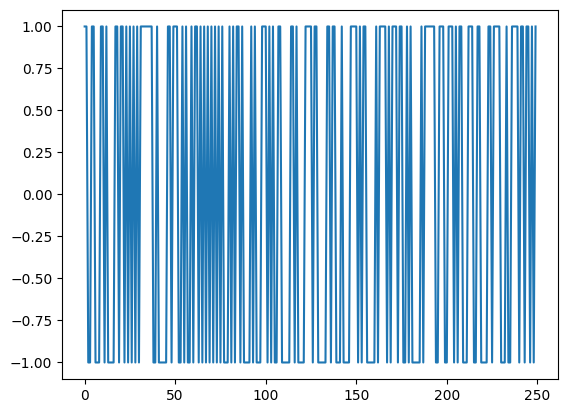

In [17]:
print(signal[-1])
pd.Series(signal).plot();